# How to Connect and Query PostgreSQL for Python

This provides and example of how to use Python and Jupyer notebooks on SWAN to connect and query PostgreSQL databases at CERN. The example provided is about generating frequency histograms using SQL.


## Setup and prerequisites

Prerquites: you need to have credential to connect to an PostgreSQL database. It is recommended that you use a test account. Contact CERN Database on Demand service to request an account if needed.

In [1]:
# This notebook uses psycopg2 to connect to PostgreSQL
# Install the driver
!pip install psycopg2-binary

import psycopg2

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Edit DB credentials
import getpass

db_user = 'myaccount' #edit

# To avoid storing connection passwords use getpas or db_config
db_pass = getpass.getpass()

db_name = 'testdb1'

port = 6600

host_name = 'dbod-mytestdb1.cern.ch' #edit

········


## Create the test table

In [3]:
# Connect to an existing database and create the test table

with psycopg2.connect(f"dbname={db_name} user={db_user} host={host_name} port={port} password={db_pass}") as pg_conn:
    cur = pg_conn.cursor()
    
    # use this drop statement if you need to recreate the table
    cur.execute("DROP TABLE if exists data")

    cur.execute("CREATE TABLE data as select random()*100 random_value from generate_series(1, 100);")

## Define the query to compute the histogram

In [4]:
table_name = "data" # table or temporary view containing the data
value_col = "random_value" # column name on which to compute the histogram
min = -20  # min: minimum value in the histogram
max = 90   # maximum value in the histogram
bins = 11  # number of histogram buckets to compute
step = (max - min) / bins
        
query = f"""
with hist as (
  select 
      width_bucket({value_col}, {min}, {max}, {bins}) as bucket,
      count(*) as cnt
  from {table_name}
  group by bucket
),
buckets as (
  select generate_series as bucket from generate_series(1,{bins})
)
select
    bucket, {min} + (bucket - 0.5) * {step} as value,
    coalesce(cnt, 0) as count
from hist right outer join buckets using(bucket)
order by bucket
"""

## Fetch the histogram data into a Pandas dataframe using SQLAlchemy

In [5]:
import pandas as pd
from sqlalchemy import create_engine

# create SQLAlchemy engine
engine = create_engine(f"postgresql+psycopg2://{db_user}:{db_pass}@{host_name}:{port}/{db_name}")


In [6]:
# query Oracle using ora_conn and put the result into a pandas Dataframe
hist_pandasDF = pd.read_sql(query, engine)

# Decription of the resulting dataframe
#
# BUCKET: the bucket number, range from 1 to bins (included)
# VALUE: midpoint value of the given bucket
# COUNT: number of values in the bucket 

hist_pandasDF


,bucket,value,count
0,1,-15.0,0
1,2,-5.0,0
2,3,5.0,10
3,4,15.0,13
4,5,25.0,10
5,6,35.0,11
6,7,45.0,8
7,8,55.0,9
8,9,65.0,12
9,10,75.0,9


In [7]:
# Optionally normalize the event count into a frequency
# dividing by the total number of events
 
hist_pandasDF["frequency"] = hist_pandasDF["count"] / sum(hist_pandasDF["count"]) 
              
hist_pandasDF


,bucket,value,count,frequency
0,1,-15.0,0,0.000000
1,2,-5.0,0,0.000000
2,3,5.0,10,0.111111
3,4,15.0,13,0.144444
4,5,25.0,10,0.111111
5,6,35.0,11,0.122222
6,7,45.0,8,0.088889
7,8,55.0,9,0.100000
8,9,65.0,12,0.133333
9,10,75.0,9,0.100000


## Histogram plotting
The first plot is a histogram with the event counts (number of events per bin). The second plot is a histogram of the events frequencies (number of events per bin normalized by the sum of the events).

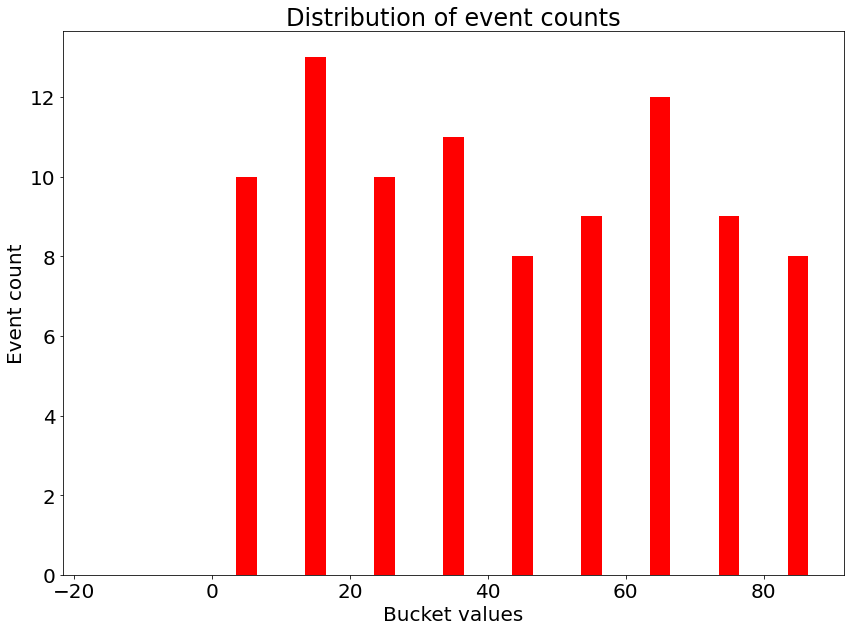

In [8]:
import matplotlib.pyplot as plt 

plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# histogram data
x = hist_pandasDF["value"]
y = hist_pandasDF["count"]

# bar plot
ax.bar(x, y, width = 3.0, color='red')

ax.set_xlabel("Bucket values")
ax.set_ylabel("Event count")
ax.set_title("Distribution of event counts")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.show()


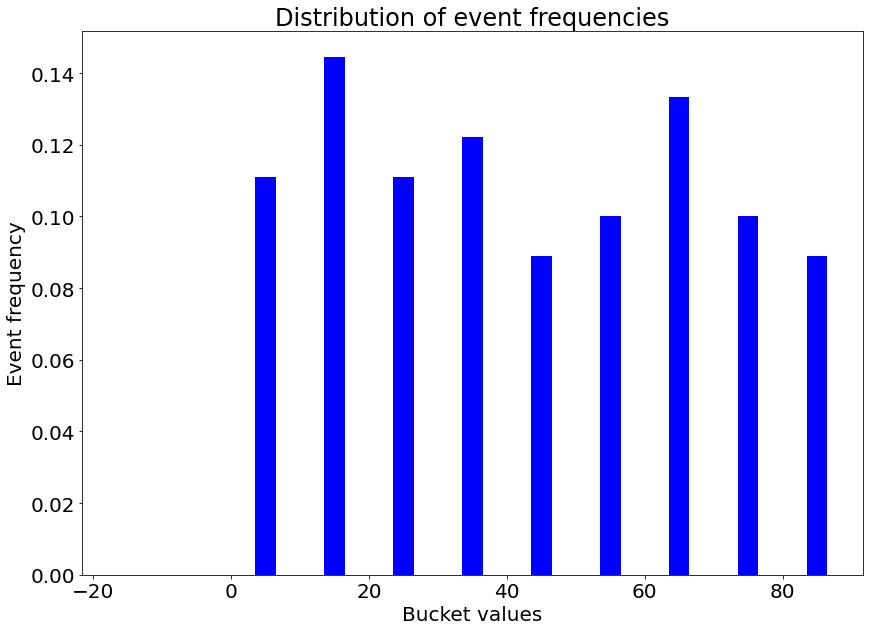

In [9]:
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# histogram data
x = hist_pandasDF["value"]
y = hist_pandasDF["frequency"]

# bar plot
ax.bar(x, y, width = 3.0, color='blue')

ax.set_xlabel("Bucket values")
ax.set_ylabel("Event frequency")
ax.set_title("Distribution of event frequencies")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.show()